In [1]:
import sys
sys.path.append("/data/ephemeral/home/book/code")
from src.data.context_data import process_context_data, str2list, split_location
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Load Data

In [2]:
data_path: str = "/data/ephemeral/home/book/code/data/"
users = pd.read_csv(data_path + "users.csv")
books = pd.read_csv(data_path + "books.csv")
train = pd.read_csv(data_path + "train_ratings.csv")

## 2. Data Preprocessing

#### 2.1 전처리 함수(process_context_data) 실행
참고. 비교를 위해 베이스라인 그대로 실행

In [ ]:
def process_context_data(users, books):

    users_ = users.copy()
    books_ = books.copy()

    books_["category"] = books_["category"].apply(lambda x: str2list(x)[0] if not pd.isna(x) else np.nan)
    # category_counts = books_['category'].value_counts() # 카테고리 빈도 계산
    # books_["category"] = books_["category"].apply(lambda x: x if category_counts.get(x, 0) >= 50 else "others") # 빈도가 50 미만인 카테고리를 "others"으로 변경
    # books_["category"] = books_["category"].apply(lambda x: x if category_counts.get(x, 0) >= 50 else category_counts.idxmax()) # 빈도가 50 미만인 카테고리를 최빈값으로 변경

    ######################### 수정
    # # 각 publisher에 대한 language의 최빈값 계산
    # mode_languages = books.groupby("publisher")["language"].agg(lambda x: x.mode()[0] if not x.mode().empty else None)
    # # 결측치를 각 publisher의 최빈값으로 대체
    # books_["language"] = books.apply(lambda row: mode_languages[row["publisher"]] if pd.isnull(row["language"]) else row["language"], axis=1)
    # # 그래도 남아 있는 결측치는 전체 최빈값으로 대체
    books_["language"] = books_["language"].fillna(books_["language"].mode()[0])
    
    ######################### 수정_ver2,3
    # # ISBN 자리수 확인
    # books['isbn_type'] = books['isbn'].apply(lambda x: 
    #     'ISBN-10' if len(''.join(filter(str.isdigit, x))) == 10 else 
    #     'ISBN-13' if len(''.join(filter(str.isdigit, x))) == 13 else 
    #     'Invalid ISBN'
    # )
    # # 언어 코드와 첫 자리를 매핑
    # language_mapping = {
    #     '0': 'en',  # 영어
    #     '3': 'de',  # 독일어
    #     '2': 'fr',  # 프랑스어
    #     '8': 'ca',  # 카탈로니아어
    #     '9': 'ms',  # 말레이어
    # }
    # # 결측치 처리 함수 
    # def fill_language(row):
    #     if pd.isnull(row['language']) and row['isbn_type'] == 'ISBN-10':
    #         first_digit = ''.join(filter(str.isdigit, row['isbn']))[0]  # 첫 자리 숫자
    #         language = language_mapping.get(first_digit, None)  # 매핑된 언어 반환
    #         ######################### 수정_ver3
    #         if language is None:  # 매핑된 언어가 없으면 'et' 반환
    #             return 'et'
    #         return language
    #     return row['language']  # 기존 언어 반환
    # books_['language'] = books.apply(fill_language, axis=1)

    ######################### 수정
    books_["publication_range"] = books_["year_of_publication"].apply(lambda x: x // 10 * 10)
    # def categorize_publication(x):
    #     if year <= 1990:
    #         return 1
    #     elif 1990 < year <= 1993:
    #         return 2
    #     elif 1993 < year <= 1996:
    #         return 3
    #     elif 1996< year <= 1999:
    #         return 4
    #     elif 1999< year <= 2002:
    #         return 5
    #     else:
    #         return 6
    # def categorize_publication(x):
    #     if x < 1970:
    #         return 1960
    #     else:
    #         return x // 10 * 10
    # books_["publication_range"] = books_["year_of_publication"].apply(categorize_publication)

    users_["location_list"] = users_["location"].apply(lambda x: split_location(x)) 
    users_["location_country"] = users_["location_list"].apply(lambda x: x[0])
    users_["location_state"] = users_["location_list"].apply(lambda x: x[1] if len(x) > 1 else np.nan)
    users_["location_city"] = users_["location_list"].apply(lambda x: x[2] if len(x) > 2 else np.nan)
    for idx, row in users_.iterrows():
        if (not pd.isna(row["location_state"])) and pd.isna(row["location_country"]):
            fill_country = users_[users_["location_state"] == row["location_state"]]["location_country"].mode()
            fill_country = fill_country[0] if len(fill_country) > 0 else np.nan
            users_.loc[idx, "location_country"] = fill_country
        elif (not pd.isna(row["location_city"])) and pd.isna(row["location_state"]):
            if not pd.isna(row["location_country"]):
                fill_state = users_[(users_["location_country"] == row["location_country"]) 
                                    & (users_["location_city"] == row["location_city"])]["location_state"].mode()
                fill_state = fill_state[0] if len(fill_state) > 0 else np.nan
                users_.loc[idx, "location_state"] = fill_state
            else:
                fill_state = users_[users_["location_city"] == row["location_city"]]["location_state"].mode()
                fill_state = fill_state[0] if len(fill_state) > 0 else np.nan
                fill_country = users_[users_["location_city"] == row["location_city"]]["location_country"].mode()
                fill_country = fill_country[0] if len(fill_country) > 0 else np.nan
                users_.loc[idx, "location_country"] = fill_country
                users_.loc[idx, "location_state"] = fill_state
    
    ######################### 수정
    # users_["age"] = users["age"].fillna(users_.groupby("location_city")["age"].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan))
    # users_["age"] = users["age"].fillna(users_.groupby("location_country")["age"].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan))
    users_["age"] = users_["age"].fillna(users_["age"].mode()[0])
    # users_["age"] = users_["age"].fillna(users_.groupby("location_city")["age"].transform(lambda x: x.mean() if not x.empty else np.nan))
    # users_["age"] = users_["age"].fillna(users_.groupby("location_country")["age"].transform(lambda x: x.mean() if not x.empty else np.nan))
    # users_["age"] = users_["age"].fillna(users_["age"].mean())

    users_["age_range"] = users_["age"].apply(lambda x: x // 10 * 10)
    # def categorize_age(x: int) -> int:
    #     if x < 20:
    #         return 10
    #     elif x >= 20 and x < 30:
    #         return 20
    #     elif x >= 30 and x < 40:
    #         return 30
    #     elif x >= 40 and x < 50:
    #         return 40
    #     elif x >= 50 and x < 60:
    #         return 50
    #     else:
    #         return 60
    # def categorize_age(x: int) -> int:
    #     if x < 20:
    #         return x // 3 * 3
    #     else:
    #         return x // 10 * 10
    # users_["age_range"] = users_["age"].apply(categorize_age)
    
    users_ = users_.drop(["location"], axis=1)

    return users_, books_

In [4]:
users_, books_ = process_context_data(users, books)

#### 2.2 데이터 병합

In [5]:
user_features = ["user_id", "age", "age_range", "location_list", "location_country", "location_state", "location_city"]
book_features = ["isbn", "book_title", "book_author", "publisher", "language", "category", "year_of_publication", "publication_range"]
sparse_cols = user_features + book_features

# 선택한 컬럼만 추출하여 데이터 조인
train_df = train.merge(users_, on="user_id", how="left")\
                .merge(books_, on="isbn", how="left")[sparse_cols + ["rating"]]

In [6]:
train_df.columns

Index(['user_id', 'age', 'age_range', 'location_list', 'location_country',
       'location_state', 'location_city', 'isbn', 'book_title', 'book_author',
       'publisher', 'language', 'category', 'year_of_publication',
       'publication_range', 'rating'],
      dtype='object')

## 3. EDA

#### 3.1 결측치 확인

In [7]:
def missing_data_info(df, df_name):
    # 결측치 수와 비율을 계산
    missing_values = df.isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100

    # 결측치 정보 데이터프레임 생성
    missing_info = pd.DataFrame({
        "Missing Values": missing_values,
        "Missing Percentage (%)": missing_percentage
    })

    # 결측치가 있는 열만 필터링
    missing_info = missing_info[missing_info["Missing Values"] > 0]

    # 결과 출력
    print(f"\n[{df_name}]")
    print(missing_info)

In [8]:
missing_data_info(books, "books")
missing_data_info(books_, "books_")
missing_data_info(users, "users")
missing_data_info(users_, "users_")
missing_data_info(train_df, "train_df")


[books]
             Missing Values  Missing Percentage (%)
book_author               1                0.000669
language              67227               44.946848
category              68851               46.032627
summary               67227               44.946848

[books_]
             Missing Values  Missing Percentage (%)
book_author               1                0.000669
summary               67227               44.946848

[users]
     Missing Values  Missing Percentage (%)
age           27833                40.87558

[users_]
                  Missing Values  Missing Percentage (%)
location_country             141                0.207073
location_state               724                1.063267
location_city               2787                4.092992

[train_df]
                  Missing Values  Missing Percentage (%)
location_country            6026                1.964178
location_state              7883                2.569468
location_city              18056               

age

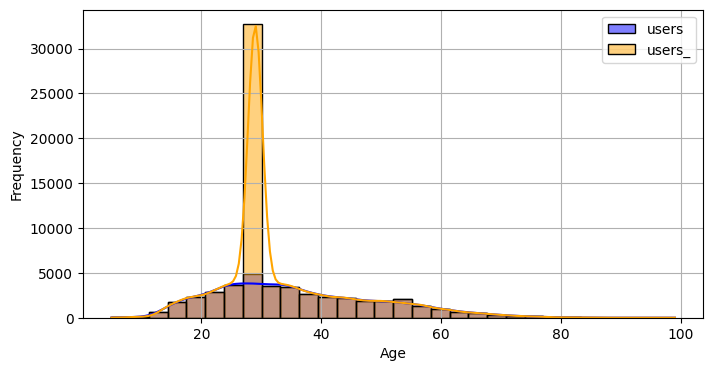

In [9]:
plt.figure(figsize=(8, 4))

sns.histplot(users["age"], bins=30, kde=True, color="blue", label="users", alpha=0.5)
sns.histplot(users_["age"], bins=30, kde=True, color="orange", label="users_", alpha=0.5)

plt.xlabel("Age")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

language

In [10]:
# ISBN 자리수 확인
books['isbn_type'] = books['isbn'].apply(lambda x: 
    'ISBN-10' if len(''.join(filter(str.isdigit, x))) == 10 else 
    'ISBN-13' if len(''.join(filter(str.isdigit, x))) == 13 else 
    'Invalid ISBN'
)

print(books['isbn_type'].unique())
print(books[books["isbn_type"] == "Invalid ISBN"])

['ISBN-10' 'Invalid ISBN']
              isbn                                         book_title  \
6       074322678X            Where You'll Find Me: And Other Stories   
39      038078243X                   Miss Zukas and the Raven's Dance   
40      067176537X  The Therapeutic Touch: How to Use Your Hands t...   
46      042518630X                                    Purity in Death   
61      042511774X                                  Breathing Lessons   
...            ...                                                ...   
149533  155882068X                   The Balloon Man (Crime Classics)   
149550  185813501X                 The Life and Works of Gustav Klimt   
149552  380520406X  Die Apotheke Manitous: Das medizinische Wissen...   
149558  202054296X                                  L'Envoi Des Anges   
149565  067161746X  The Bachelor Home Companion: A Practical Guide...   

                book_author  year_of_publication                 publisher  \
6               An

In [11]:
print(f"origin: {books['language'].unique()}")
filtered_language = books.groupby('language').filter(lambda x: len(x) >= 10)['language'].unique()
print(f"filter: {filtered_language}")

filtered_books = books[(books['isbn_type'] == 'ISBN-10') & (books['language'].isin(filtered_language))]
print(filtered_books.groupby('language')['isbn'].apply(lambda x: x.str[0].unique()))

origin: ['en' nan 'de' 'fr' 'es' 'ca' 'it' 'da' 'nl' 'pt' 'ro' 'no' 'ms' 'la' 'ru'
 'el' 'zh-CN' 'th' 'gl' 'ja' 'fa' 'eo' 'gd' 'ga' 'vi' 'zh-TW' 'ko']
filter: ['en' 'de' 'fr' 'es' 'ca' 'it' 'da' 'nl' 'pt' 'ms']
language
ca                         [8]
da          [1, 3, 8, 0, 9, 2]
de                   [3, 0, 2]
en    [0, 1, 8, 2, 3, 9, 4, 5]
es             [8, 9, 0, 1, 3]
fr                [2, 0, 3, 8]
it                   [8, 0, 3]
ms                         [9]
nl             [0, 3, 9, 1, 2]
pt                   [9, 8, 0]
Name: isbn, dtype: object


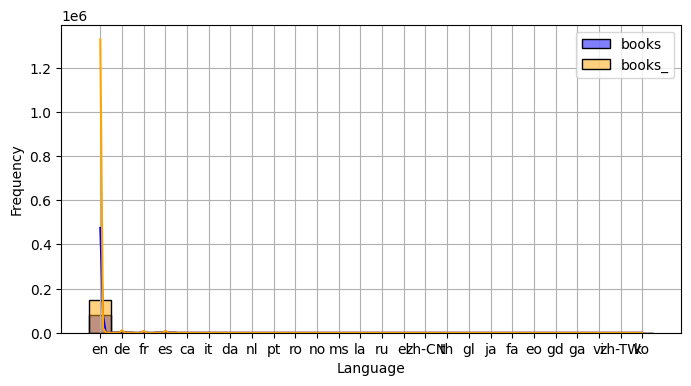

In [12]:
plt.figure(figsize=(8, 4))

sns.histplot(books["language"], bins=30, kde=True, color="blue", label="books", alpha=0.5)
sns.histplot(books_["language"], bins=30, kde=True, color="orange", label="books_", alpha=0.5)

plt.xlabel("Language")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

category

In [19]:
# 1. category 컬럼에 결측치가 있는 isbn 식별
missing_category_isbns = books[pd.isnull(books_["category"])]["isbn"]

#### 3.2 범주화

year_of_publication -> publication_range

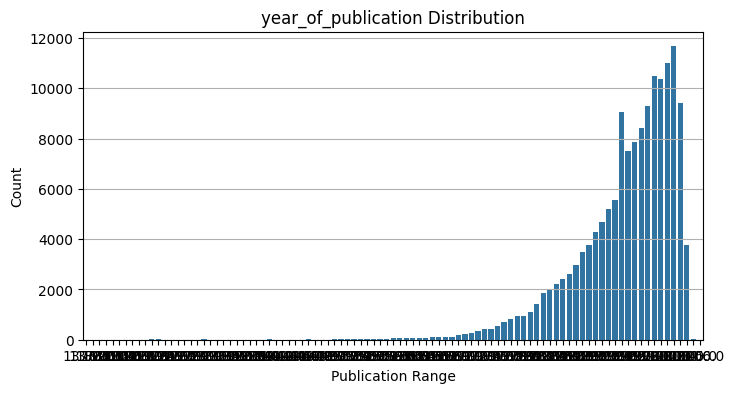

In [13]:
plt.figure(figsize=(8, 4))
sns.countplot(data=books_, x='year_of_publication')
plt.title('year_of_publication Distribution')
plt.xlabel('Publication Range')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show()

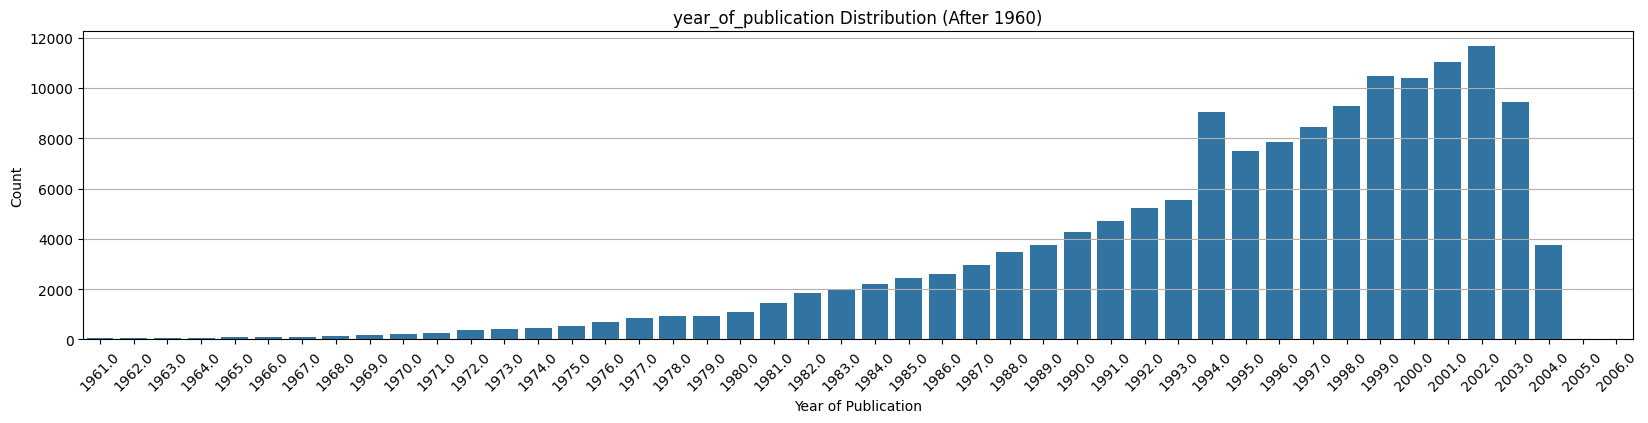

In [14]:
books_after_1960 = books_[books_['year_of_publication'] > 1960]
plt.figure(figsize=(20, 4))
sns.countplot(data=books_after_1960, x='year_of_publication')
plt.title('year_of_publication Distribution (After 1960)')
plt.xlabel('Year of Publication')
plt.ylabel('Count')
plt.xticks(rotation=45)  # x축 레이블 회전 (가독성 증가)
plt.grid(axis='y')
plt.show()

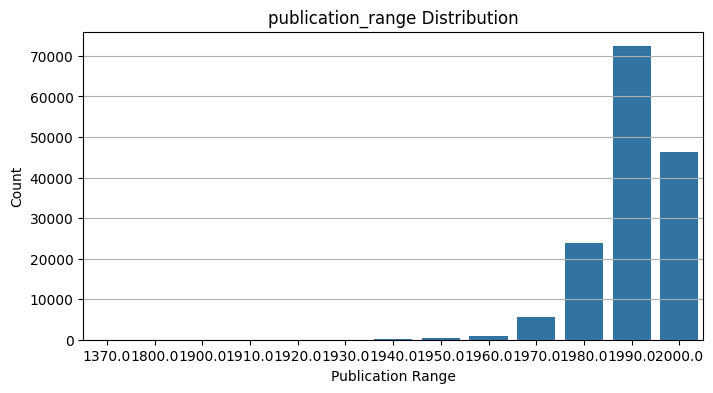

In [15]:
plt.figure(figsize=(8, 4))
sns.countplot(data=books_, x='publication_range')
plt.title('publication_range Distribution')
plt.xlabel('Publication Range')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show()

age

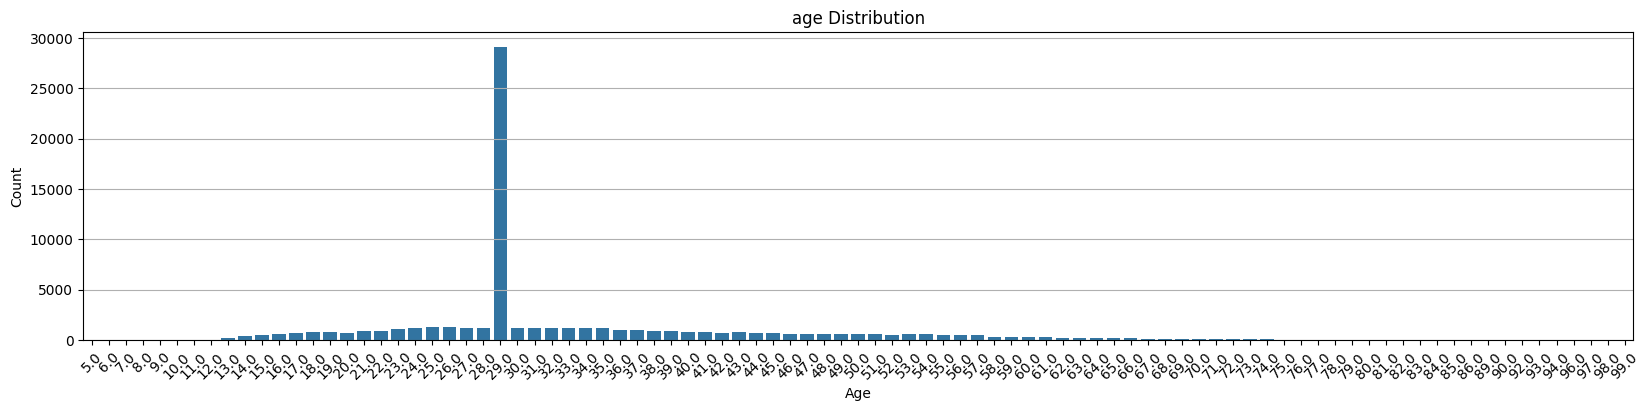

In [16]:
plt.figure(figsize=(20, 4))
sns.countplot(data=users_, x='age')
plt.title('age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

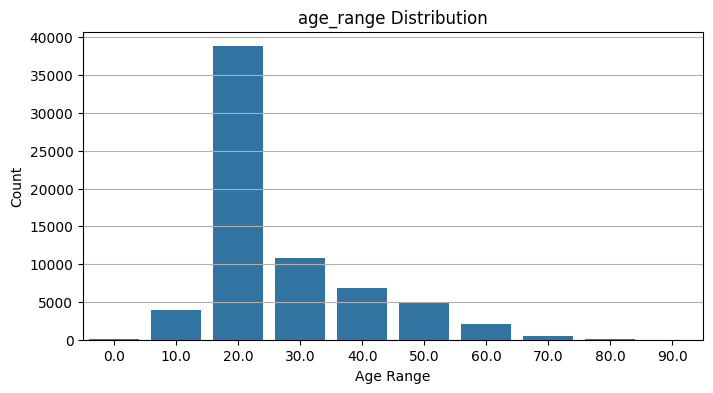

In [17]:
plt.figure(figsize=(8, 4))
sns.countplot(data=users_, x='age_range')
plt.title('age_range Distribution')
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show()

category

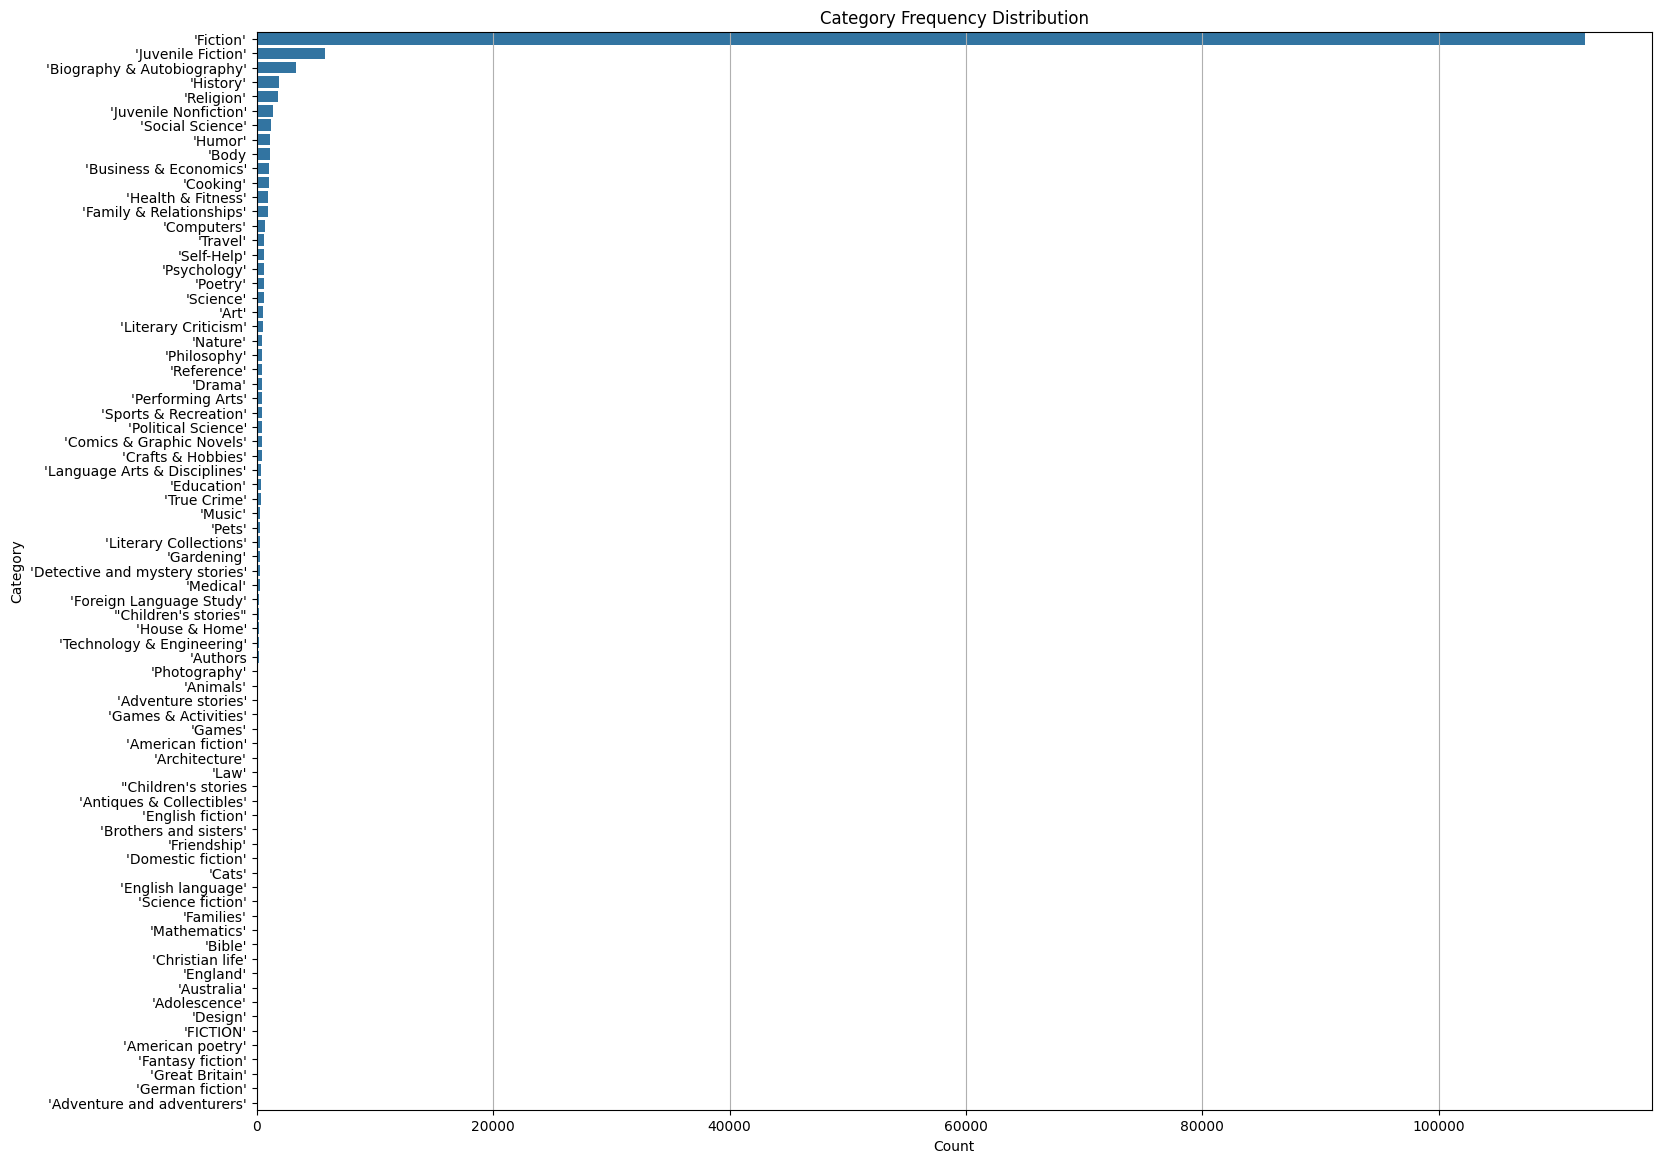

전체 카테고리 수: 75
50개 이상인 카테고리 수: 75
50개 이상인 카테고리의 비율: 100.00%


In [18]:
category_counts = books_["category"].value_counts()
filtered_counts = category_counts[category_counts >= 50]

plt.figure(figsize=(18, 14))
sns.barplot(x=filtered_counts.values, y=filtered_counts.index)
plt.title('Category Frequency Distribution')
plt.xlabel('Count')
plt.ylabel('Category')
plt.grid(axis='x')
plt.show()

total_categories = len(category_counts)
num_above = len(filtered_counts)
percentage_above = (num_above / total_categories) * 100 if total_categories > 0 else 0
print(f"전체 카테고리 수: {total_categories}")
print(f"50개 이상인 카테고리 수: {num_above}")
print(f"50개 이상인 카테고리의 비율: {percentage_above:.2f}%")